In [395]:
from qiskit import QuantumCircuit
import math
from math import e #euler's number
import numpy as np
import cmath #for complex numbers
import random
import re
import matplotlib.pyplot as plt

In [396]:
numShots = 1000

In [397]:
# QASM Text compiler
def read_from_file(file_path):
    f = open(file_path, "r")

    # header of QASM file
    f.readline()
    f.readline()
    f.readline()

    # get number of qubits
    line = f.readline()
    num_qubits = re.sub("\D", "", line)

    # get number of classical bits
    line = f.readline()
    num_bits = re.sub("\D", "", line)

    print("number of qubits " + num_qubits)
    print("number of bits " + num_bits)
    
    # get gates and corresponding qubits
    gates_list = []
    while True:
        line = str(f.readline())
        print("line: " + line)

        if not line:
            break
        if line[0:2] == "cx":
            print("cx gate detected")
            gates_list.append("cx " + line[5] + " " + line[11]) 
        elif line[0] == "u":
            qi = line[-4]
            line=line[2:-8]
            t = str(re.split(',\s',line)[0])
            p = str(re.split(',\s',line)[1])
            l = str(re.split(',\s',line)[2])
            gates_list.append("u "+t+" "+p+" "+l+" "+qi) 
        else:
            gate = re.split('\s',line)[0]
            qi = line[-4]
            gates_list.append(gate+" "+qi)


        
    return int(num_qubits), num_bits, gates_list


In [398]:
def useGate(gate, numQubits, qubitState, qi):
    Igate = [[1,0],[0,1]]
    gateTensor = 0
    if qi == numQubits-1:
        gateTensor = gate
        numQubits -= 1
    else:
        gateTensor = Igate
        numQubits -= 1
    while numQubits>0:
        if numQubits-1 == qi:
            gateTensor = np.kron(gateTensor,gate)
            numQubits-=1
        else:
            gateTensor = np.kron(gateTensor,Igate)
            numQubits-=1
    print('gate tensor:')
    print(gateTensor)
    print('dot product')
    print(np.dot(gateTensor,qubitState))
    return np.dot(gateTensor,qubitState)

# applies unitary gate
def unitary(qubitState, numQubits, qi, t, p, l):
    j = complex(0,1)
    uMatrix = [[0,0],[0,0]]
    uMatrix[0][0]=math.cos(t/2)
    uMatrix[0][1]=(-e**(j*l))*math.sin(t/2)
    uMatrix[1][0]=(e**(j*p))*math.sin(t/2)
    uMatrix[1][1]=(e**(j*(l+p)))*math.cos(t/2)
    return useGate(uMatrix,numQubits,qubitState,qi)

# applies a gate with kronecker products
def apply_single_gate(gateType, numQubits, qubitState, qubitIndex):
    i = complex(0,1) # use i for complex numbers
    # define matrices for gates
    X_gate = [[0, 1], [1, 0]]
    Y_gate = [[0, -1j], [1j, 0]]
    Z_gate = [[1, 0], [0, -1]]
    I_gate = [[1, 0], [0, 1]]
    H_gate = [[1/math.sqrt(2), 1/math.sqrt(2)], [1/math.sqrt(2), -1/math.sqrt(2)]]
    S_gate = [[1, 0], [0, 1j]]
    SDG_gate = [[1, 0], [0, -1j]]
    T_gate = [[1, 0], [0, (e**(i*math.pi/4))]]
    TDG_gate = [[1, 0], [0, (e**(-i*math.pi/4))]]
    Q_gate = [[1/math.sqrt(2), 1/math.sqrt(2)], [i/math.sqrt(2), -i/math.sqrt(2)]]
    QDG_gate = [[1/math.sqrt(2), -i/math.sqrt(2)], [1/math.sqrt(2), i/math.sqrt(2)]]

    # select appropriate gate
    qubitIndex = int(qubitIndex)
    if gateType == "x":
        return useGate(X_gate,numQubits,qubitState,qubitIndex)
    elif gateType == "y":
        return useGate(Y_gate,numQubits,qubitState,qubitIndex)
    elif gateType == "z":
        return useGate(Z_gate,numQubits,qubitState,qubitIndex)
    elif gateType == "h":
        return useGate(H_gate,numQubits,qubitState,qubitIndex)
    elif gateType == "s":
        return useGate(S_gate,numQubits,qubitState,qubitIndex)
    elif gateType == "sdg":
        return useGate(SDG_gate,numQubits,qubitState,qubitIndex)
    elif gateType == "t":
        return useGate(T_gate,numQubits,qubitState,qubitIndex)
    elif gateType == "tdg":
        return useGate(TDG_gate,numQubits,qubitState,qubitIndex)
    elif gateType == "q":
        return useGate(Q_gate,numQubits,qubitState,qubitIndex)
    elif gateType == "qdg":
        return useGate(QDG_gate,numQubits,qubitState,qubitIndex)
    else:
        return useGate(I_gate,numQubits,qubitState,qubitIndex)


In [399]:
# measure a qubit state
def measure_all_qubits(qubitState, results, noise):
    convert = np.transpose(qubitState)
    # print(convert)
    probabilities = []
    for i in range(len(qubitState)):
        probabilities.append(abs(convert.tolist()[0][i])**2)
    choices = []
    for i in range(qubitState.size):
        choices.append(i)

    
    # randomly select outcome
    outcome = np.random.choice(choices, p = probabilities)
    if (random.random() < noise):
        results[random.choice(choices)] += 1
    else:
        results[outcome] += 1

    
    return results

In [400]:
# Methods for CNOT gate
def swap(qTensor, numQubits, i1, i2):
    Imatrix = [[1,0],[0,1]]
    SWAPmatrix = [[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]
    gateTensor = 0
    if i2 == numQubits-1:
        gateTensor = SWAPmatrix
        numQubits -= 2
    else:
        gateTensor = Imatrix
        numQubits -= 1
    while numQubits>0:
        if numQubits-1 == i2:
            gateTensor = np.kron(gateTensor,SWAPmatrix)
            numQubits-=2
        else:
            gateTensor = np.kron(gateTensor,Imatrix)
            numQubits-=1
    return np.dot(gateTensor,qTensor)
    
def applyCNOT(qTensor, numQubits, control):
    Imatrix = [[1,0],[0,1]]
    CNOTmatrix = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]
    gateTensor = 0
    if control == numQubits-1:
        gateTensor = CNOTmatrix
        numQubits -= 2
    else:
        gateTensor = Imatrix
        numQubits -= 1
    
    while numQubits > 0:
        if numQubits-1 == control:
            gateTensor = np.kron(gateTensor,CNOTmatrix)
            numQubits -= 2
        else:
            gateTensor = np.kron(gateTensor,Imatrix)
            numQubits -= 1
    return np.dot(gateTensor,qTensor)
    

def CNOT_gate(qTensor, numQubits, c, n):
    separation = c-n
    if separation > 0: # Ex: CNOT(4,1)
        for i in range(separation-1):
            qTensor = swap(qTensor,numQubits,n+i,n+1+i)
        qTensor = applyCNOT(qTensor,numQubits,c)
        for i in range(separation-1):
            qTensor = swap(qTensor,numQubits,c-2-i,c-1-i)
        return (qTensor)
        
    elif separation < 0: # Ex: CNOT(1,3)
        for i in range(abs(separation)):
            qTensor = swap(qTensor,numQubits,c+i,c+1+i)
        qTensor = applyCNOT(qTensor,numQubits,n)
        for i in range(abs(separation)):
            qTensor = swap(qTensor,numQubits,n-1-i,n-i)
        return (qTensor)

In [401]:
# histogram
def histogram_generator(measurement_results): 
    num_bits = int(math.sqrt(len(measurement_results)))

    data = {}
    for i in range(len(measurement_results)):
        data[f"{i:0{num_bits}b}"] = measurement_results[i]

    states = list(data.keys())
    count = list(data.values())

    plt.bar(states, count, color ='blue', width = 0.4)
    plt.xlabel("Computational Basis States")
    plt.ylabel("Counts")
    plt.title("Histogram")
    plt.show()

number of qubits 4
number of bits 4
line: h q[0];

line: h q[2];

line: cx q[0], q[1];

cx gate detected
line: cx q[2], q[3];

cx gate detected
line: x q[2];

line: 
['h 0', 'h 2', 'cx 0 1', 'cx 2 3', 'x 2']
gate_string h
gate tensor:
[[ 0.70710678  0.70710678  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.70710678 -0.70710678  0.         -0.          0.         -0.
   0.         -0.          0.         -0.          0.         -0.
   0.         -0.          0.         -0.        ]
 [ 0.          0.          0.70710678  0.70710678  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.          0.70710678 -0.70710678  0.         -0.
   0.         -0.          0.         -0.          0.         -0.
   0.         -0.          0.         -0.        ]
 [ 0.          0.          0.    

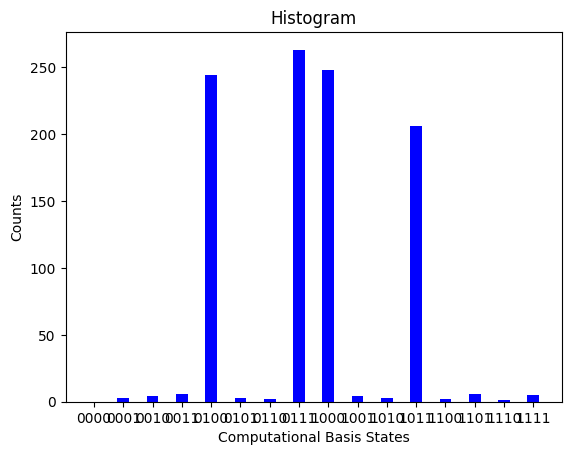

In [402]:
# main cell that calls everything
# filepath = "cnot_gate_test.qasm"    # use your own file path
filepath = "bellStates.qasm"    # use your own file path
numQubits, numCbits, gatelist = read_from_file(filepath)
print(gatelist)

#numShots = int(input("How many Shots will the experiment have? "))
#noise = float(input("How much noise should the experiment have "))
numShots = 1000
noise = 0.05

qubitState = np.matrix([[1], [0]])
for i in range(numQubits - 1):
    zero_qubit = np.matrix([[1], [0]], dtype = complex)
    qubitState = np.kron(qubitState, zero_qubit)

for i in gatelist:
    gate_string = i.split(' ')[0]
    print ("gate_string " + gate_string)
    
    #calls control not
    if gate_string == "cx":
        control_qubit = i.split(' ')[1]
        target_qubit = i.split(' ')[2]
        print("control is " + str(control_qubit) + " and target is " + str(target_qubit)) 
        print(" state before " + str(qubitState))
        qubitState = CNOT_gate(qubitState, numQubits, int(control_qubit), int(target_qubit)) 
        print(qubitState)
    
    #calls unitary
    elif gate_string == "u":
        print(i)
        t=int(i.split(' ')[1])
        p=int(i.split(' ')[2])
        l=int(i.split(' ')[3])
        qubit_index=int(i.split(' ')[4])
        qubitState = unitary(qubitState, numQubits, qubit_index, t, p, l)
    
    #calls other gates
    else:
        qubit_index = i.split(' ')[1]
        qubitState = apply_single_gate(gate_string, numQubits, qubitState, qubit_index)
        print(qubitState)

print("final state is ")
print(qubitState)

measurement_results = np.zeros(qubitState.size)
for i in range(numShots):
    measure_all_qubits(qubitState, measurement_results, noise)
print(measurement_results)

# plot histogram
histogram_generator(measurement_results)